In [1]:
import os
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn import preprocessing 

cwd = os.getcwd()
file = '/'.join(cwd.split('/')) + '/WA_Fn-UseC_-Sales-Win-Loss.csv'
data = pd.read_csv(file, index_col = 0)

In [2]:
# Data Preparition
# First change opportunity result(our target variable) to numeric
data_clean = data.copy()
minority = data_clean['Opportunity Result'].value_counts().idxmin()
result = np.array((data_clean['Opportunity Result'] == minority).astype(int))
data_clean = data_clean.drop(['Opportunity Result'], axis = 1)
# For each categorical variables in the dataset, try to assign an unique indicator variable 
#      for each different category
# (This may not be a good step because it adds too many columns, but we'll see)
for col in data_clean.columns:
    if is_string_dtype(data_clean[col]):
        name_set = set(data_clean[col])
        for name in name_set:
            data_clean[' '.join([col, name, 'indicator'])] = (data_clean[col] == name).astype(int)
        data_clean = data_clean.drop([col], axis = 1)
# Check if there is any null value in our dataset
if data_clean.isnull().any().any():
    print('NO!!!!!')
# Gladly, we don't have any

# Normalize our dataset
scale = preprocessing.StandardScaler()
data_clean = pd.DataFrame(scale.fit_transform(data_clean), columns = data_clean.columns)
data_clean['result'] = result

In [3]:
data_clean.describe()

,Elapsed Days In Sales Stage,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,Client Size By Employee Count,Revenue From Client Past Two Years,Ratio Days Identified To Total Days,Ratio Days Validated To Total Days,...,Region Midwest indicator,Route To Market Telecoverage indicator,Route To Market Other indicator,Route To Market Fields Sales indicator,Route To Market Telesales indicator,Route To Market Reseller indicator,Competitor Type None indicator,Competitor Type Unknown indicator,Competitor Type Known indicator,result
count,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,...,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,7.802500e+04,78025.000000
mean,-3.091560e-14,1.032697e-14,2.873557e-15,-1.546493e-14,3.204324e-16,1.236147e-13,1.052410e-13,5.522483e-15,-8.668781e-15,-3.929955e-16,...,-4.756321e-14,-6.044190e-15,-1.237262e-14,-4.050461e-15,2.243096e-14,6.149945e-16,1.848216e-14,2.841542e-15,-2.199765e-14,0.225915
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,...,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,0.418186
min,-1.639821e+00,-1.306231e+00,-9.999325e-01,-9.850178e-01,-6.881732e-01,-5.020929e-01,-4.989112e-01,-3.260160e-01,-5.563645e-01,-1.089806e+00,...,-6.072393e-01,-8.942481e-02,-1.949215e-01,-9.560927e-01,-1.830632e-01,-8.962909e-01,-3.668951e-01,-1.631862e+00,-4.272440e-01,0.000000
25%,-9.251439e-01,-6.383324e-01,-7.608337e-01,-7.435082e-01,-5.755269e-01,-5.020929e-01,-4.989112e-01,-3.260160e-01,-5.563645e-01,-1.089806e+00,...,-6.072393e-01,-8.942481e-02,-1.949215e-01,-9.560927e-01,-1.830632e-01,-8.962909e-01,-3.668951e-01,-1.631862e+00,-4.272440e-01,0.000000
50%,-2.239376e-02,2.956645e-02,-2.826361e-01,-2.604891e-01,-3.201953e-01,-5.020929e-01,-4.989112e-01,-3.260160e-01,-5.563645e-01,-8.997158e-02,...,-6.072393e-01,-8.942481e-02,-1.949215e-01,-9.560927e-01,-1.830632e-01,-8.962909e-01,-3.668951e-01,6.127969e-01,-4.272440e-01,0.000000
75%,8.051272e-01,2.956645e-02,4.346603e-01,4.640396e-01,1.010943e-01,-5.020929e-01,-4.989112e-01,-3.260160e-01,-1.599568e-02,1.141967e+00,...,1.646797e+00,-8.942481e-02,-1.949215e-01,1.045924e+00,-1.830632e-01,1.115709e+00,-3.668951e-01,6.127969e-01,-4.272440e-01,0.000000
max,6.259242e+00,1.338754e+01,1.143321e+01,1.157348e+01,6.821580e+00,2.734707e+00,2.804863e+00,3.973747e+00,2.183495e+00,1.141967e+00,...,1.646797e+00,1.118258e+01,5.130271e+00,1.045924e+00,5.462593e+00,1.115709e+00,2.725575e+00,6.127969e-01,2.340583e+00,1.000000


In [4]:
# Since this is just a trial, split training and test data randomly(Later we could use k-fold cross validation)
length = len(data_clean['result'])
train_index = []
test_index = []
for i in range(length):
    train_index.append(i) if np.random.rand() <= 0.8 else test_index.append(i)
data_train = data_clean.iloc[train_index, :]
data_test = data_clean.iloc[test_index, :]

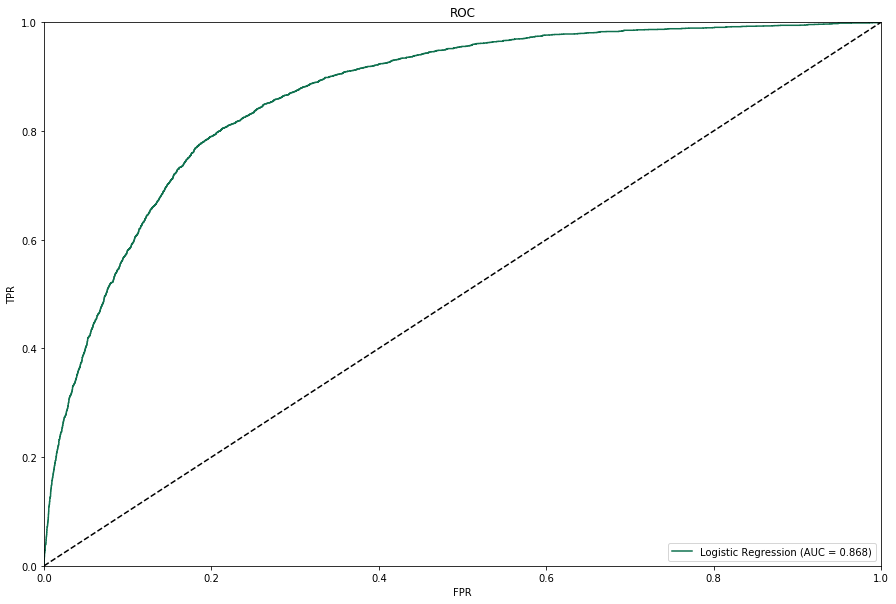

In [98]:
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
%matplotlib inline
# Firstly, run a Logistic Regression
lg = linear_model.LogisticRegression(C = 1e30)
lg.fit(data_train.drop(['result'], axis = 1), data_train['result'])
total_lg = lg.predict_proba(data_test.drop(['result'], axis = 1))
result_lg = total_lg[:, 1]

def plotROC(preds, truth, name):
    fpr, tpr, thresholds = roc_curve(truth, preds)
    roc_auc = auc(fpr, tpr)
    # chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    #create the plot
    plt.plot(fpr, tpr, color = c, label = name + ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

# Plot ROC for both models
fig = plt.figure(figsize = (15, 10))
plotROC(result_lg, data_test['result'], 'Logistic Regression')
plt.show()

The above AUC score is quite convincing(to my surprise)...
I think for our problem, since the opportunity amount varies from instance to instance, the profit IBM will get from each instance varies as well. So it's not likely for us to choose a universal threshold for all the instances.

In [102]:
# Do a decision tree and support vector machine and compare them with logistic regression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
DT = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 2000, min_samples_leaf = 200)
DT.fit(data_train.drop(['result'], axis = 1), data_train['result'])
total_DT = DT.predict_proba(data_test.drop(['result'], axis = 1))
result_DT = total_DT[:, 1]

svm = svm.SVC(kernel = "linear")
svm.fit(data_train.drop(['result'], axis = 1), data_train['result'])
#total_svm = svm.predict_proba(data_test.drop(['result'], axis = 1))
result_svm = svm.decision_function(data_test.drop(['result'], axis = 1))

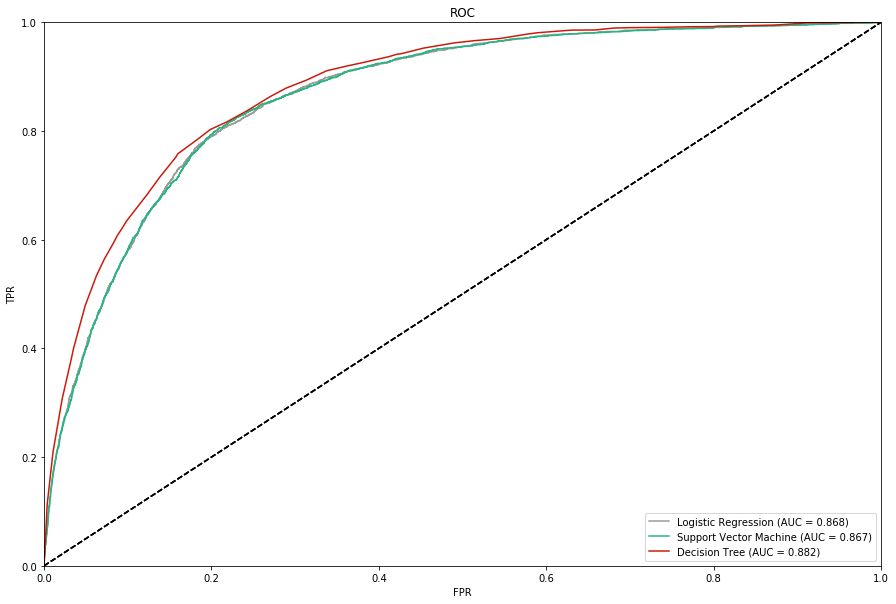

In [65]:
#Plot
fig = plt.figure(figsize = (15, 10))
plotROC(result_lg, data_test['result'], 'Logistic Regression')
plotROC(result_svm, data_test['result'], 'Support Vector Machine')
plotROC(result_DT, data_test['result'], 'Decision Tree')
plt.show()

In [8]:
# Find feature importances derived by Decision Tree and logistic regression, make it a dataframe
imp = dict(zip(data_clean.columns[0: -1], [[i] for i in DT.feature_importances_]))
feature_imp = pd.DataFrame.from_dict(data = imp, orient = 'index')
feature_imp.columns = ['Decision Tree']
feature_imp['Logistic Regression'] = lg.coef_[0, :]

In [9]:
feature_imp

,Decision Tree,Logistic Regression
Elapsed Days In Sales Stage,0.012191,-0.084869
Sales Stage Change Count,0.097965,0.601323
Total Days Identified Through Closing,0.000000,-0.115401
Total Days Identified Through Qualified,0.322435,-1.244429
Opportunity Amount USD,0.081975,0.331311
Client Size By Revenue,0.000000,0.056909
Client Size By Employee Count,0.000475,0.053364
Revenue From Client Past Two Years,0.207801,0.607670
Ratio Days Identified To Total Days,0.023905,-0.665764
Ratio Days Validated To Total Days,0.008868,-0.449770


It seems like most of the indicator variable doesn't have much influence on the classfication

In [14]:
# Second edition
# Do some feature selection
# First we use Decision Tree's feature importance to cut some features
imp = dict(zip(data_clean.columns[0: -1], [[i] for i in DT.feature_importances_]))
feature_imp = pd.DataFrame.from_dict(data = imp, orient = 'index')
feature_imp.columns = ['Decision Tree']
feature_imp['Logistic Regression'] = lg.coef_[0, :]
feature_imp = feature_imp[feature_imp['Decision Tree'] >= 0.01]
feature_imp

,Decision Tree,Logistic Regression
Elapsed Days In Sales Stage,0.012191,-0.084869
Sales Stage Change Count,0.097965,0.601323
Total Days Identified Through Qualified,0.322435,-1.244429
Opportunity Amount USD,0.081975,0.331311
Revenue From Client Past Two Years,0.207801,0.607670
Ratio Days Identified To Total Days,0.023905,-0.665764
Ratio Days Qualified To Total Days,0.185523,0.101977
Route To Market Reseller indicator,0.056820,0.164134


In [32]:
# Drop unimportant features
should_drop = list(set(data_clean.columns) - set(feature_imp.index))
should_drop.remove('result')
n1_df = data_clean.drop(should_drop, axis = 1)
# Re-split samples from the important dataframe
leng = len(n1_df['result'])
train_in = []
test_in = []
for i in range(leng):
    train_in.append(i) if np.random.rand() <= 0.8 else test_in.append(i)
n1_train = n1_df.iloc[train_in, :]
n1_test = n1_df.iloc[test_in, :]

# Do logistic regression again
n1_lg = linear_model.LogisticRegression(C = 1e30)
n1_lg.fit(n1_train.drop(['result'], axis = 1), n1_train['result'])
n1result_lg = n1_lg.predict_proba(n1_test.drop(['result'], axis = 1))[:, 1]
# Do Decision Tree again
n1_DT = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 2000, min_samples_leaf = 200)
n1_DT.fit(n1_train.drop(['result'], axis = 1), n1_train['result'])
n1result_DT = n1_DT.predict_proba(n1_test.drop(['result'], axis = 1))[:, 1]
# Do svm again
n1_svm = svm.SVC(kernel = "linear")
n1_svm.fit(n1_train.drop(['result'], axis = 1), n1_train['result'])
n1result_svm = n1_svm.decision_function(n1_test.drop(['result'], axis = 1))

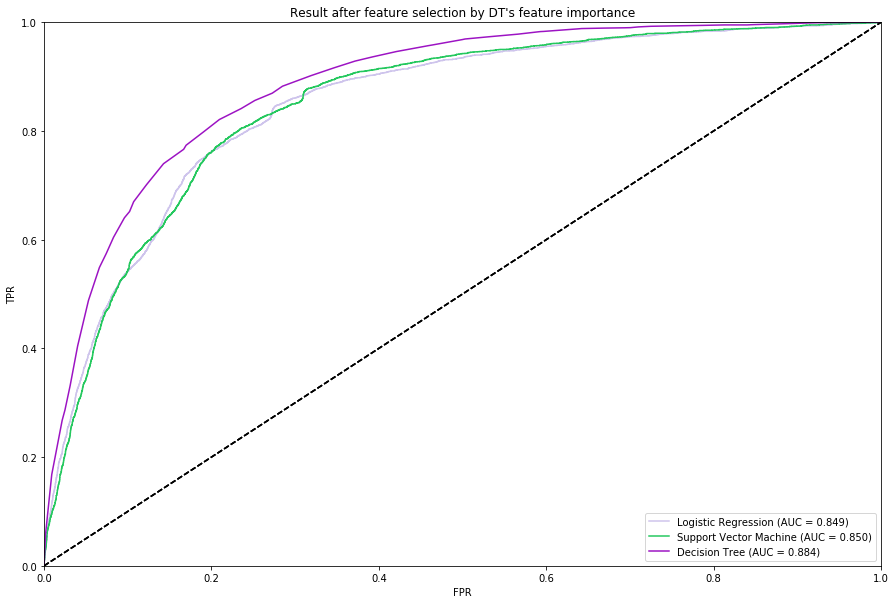

In [33]:
#Plot
fig = plt.figure(figsize = (15, 10))
plotROC(n1result_lg, n1_test['result'], 'Logistic Regression')
plotROC(n1result_svm, n1_test['result'], 'Support Vector Machine')
plotROC(n1result_DT, n1_test['result'], 'Decision Tree')
plt.title('Result after feature selection by DT\'s feature importance')
plt.show()

Looks like DT's performance doesn't change much, but logistic regrssion and svm suffered a bit, which is reasonable.

In [42]:
# Secondly we do feature selection by mutual information
from sklearn.feature_selection import mutual_info_classif as mic
mi_list = mic(data_clean.drop('result', axis = 1).values, data_clean['result'].values)
mi_list = list(mi_list)
mi_list.append(1)

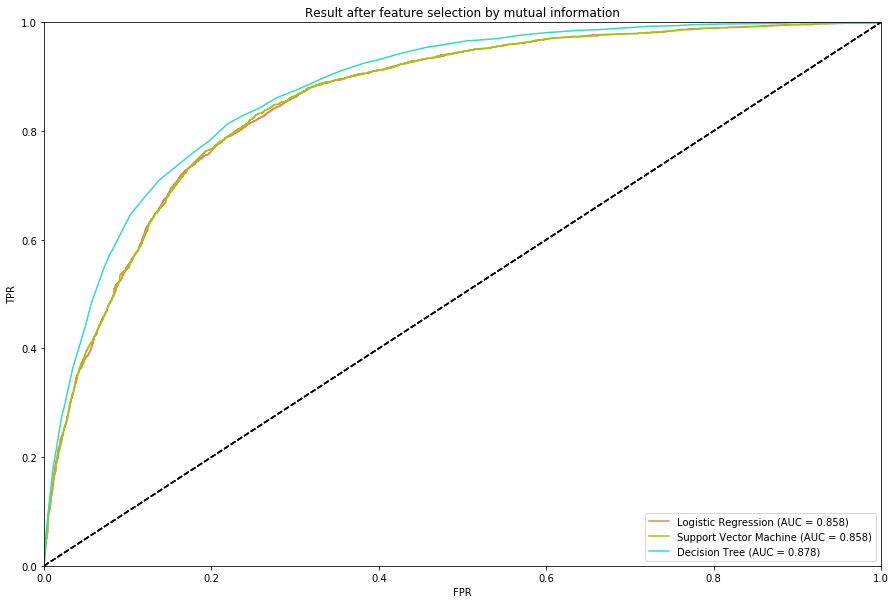

In [62]:
drop_columns = list(set(data_clean.columns) - set(data_clean.columns[np.array(mi_list) >= 0.01]))
n2_df = data_clean.drop(drop_columns, axis = 1)
# Re-split samples from the important dataframe
n2_train = n2_df.iloc[train_in, :]
n2_test = n2_df.iloc[test_in, :]

# Do logistic regression again
n2_lg = linear_model.LogisticRegression(C = 1e30)
n2_lg.fit(n2_train.drop(['result'], axis = 1), n2_train['result'])
n2result_lg = n2_lg.predict_proba(n2_test.drop(['result'], axis = 1))[:, 1]
# Do Decision Tree again
n2_DT = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 2000, min_samples_leaf = 200)
n2_DT.fit(n2_train.drop(['result'], axis = 1), n2_train['result'])
n2result_DT = n2_DT.predict_proba(n2_test.drop(['result'], axis = 1))[:, 1]
# Do svm again
n2_svm = svm.SVC(kernel = "linear")
n2_svm.fit(n2_train.drop(['result'], axis = 1), n2_train['result'])
n2result_svm = n2_svm.decision_function(n2_test.drop(['result'], axis = 1))
#Plot
fig = plt.figure(figsize = (15, 10))
plotROC(n2result_lg, n2_test['result'], 'Logistic Regression')
plotROC(n2result_svm, n2_test['result'], 'Support Vector Machine')
plotROC(n2result_DT, n2_test['result'], 'Decision Tree')
plt.title('Result after feature selection by mutual information')
plt.show()

It seems like all 3 methods' score decresed a little bit, though not much.

In [51]:
# Thirdly, use principal component analysis to do feature reduction
from sklearn.decomposition import PCA
pca = PCA(svd_solver = 'full')
pca.fit(data_clean.drop('result', axis = 1).values)
print(pca.singular_values_) 

[5.04212546e+02 4.86840358e+02 4.37506851e+02 4.00117005e+02
 3.96243607e+02 3.83317980e+02 3.69919503e+02 3.54230531e+02
 3.41871532e+02 3.27814594e+02 3.17322064e+02 3.08397828e+02
 3.07729230e+02 3.05270893e+02 2.98688997e+02 2.97502591e+02
 2.95109906e+02 2.93479162e+02 2.90901312e+02 2.89033946e+02
 2.84578147e+02 2.78636661e+02 2.75491844e+02 2.72082316e+02
 2.69367760e+02 2.62132406e+02 2.56231685e+02 2.46058948e+02
 2.23845314e+02 2.12854192e+02 1.90971759e+02 1.32904457e+02
 1.19184905e+02 3.36316417e+01 2.62586907e-13 2.46851272e-13
 2.13696117e-13 1.43342163e-13 1.10104128e-13 8.45766551e-14
 6.74086454e-14 4.52321455e-14]


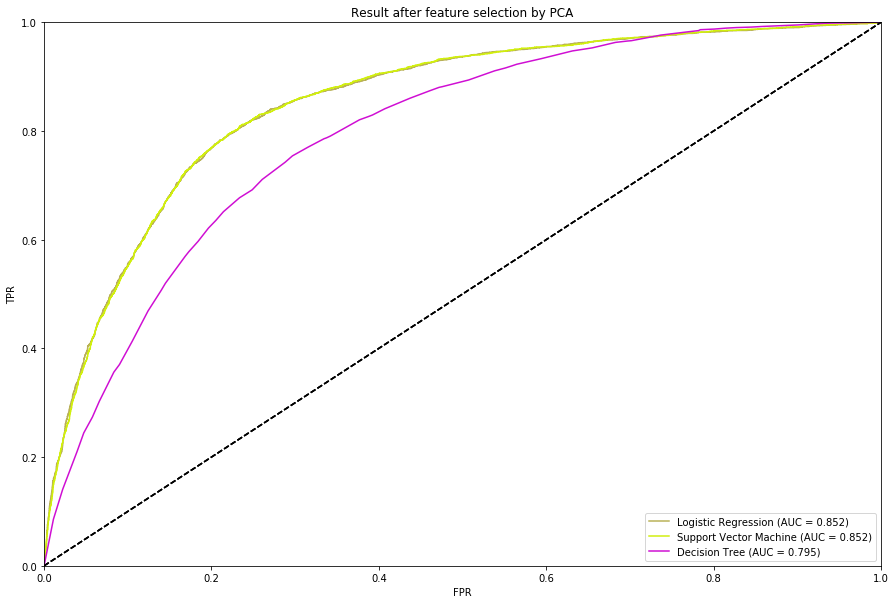

In [63]:
# It seems like a reasonable number of component should be about 30
new_pca = PCA(n_components = 30)
n3_data = new_pca.fit_transform(data_clean.drop('result', axis = 1).values)
n3_df = pd.DataFrame(n3_data)
n3_df['result'] = data_clean['result']
# Re-split samples from the important dataframe
n3_train = n3_df.iloc[train_in, :]
n3_test = n3_df.iloc[test_in, :]

# Do logistic regression again
n3_lg = linear_model.LogisticRegression(C = 1e30)
n3_lg.fit(n3_train.drop(['result'], axis = 1), n3_train['result'])
n3result_lg = n3_lg.predict_proba(n3_test.drop(['result'], axis = 1))[:, 1]
# Do Decision Tree again
n3_DT = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 2000, min_samples_leaf = 200)
n3_DT.fit(n3_train.drop(['result'], axis = 1), n3_train['result'])
n3result_DT = n3_DT.predict_proba(n3_test.drop(['result'], axis = 1))[:, 1]
# Do svm again
n3_svm = svm.SVC(kernel = "linear")
n3_svm.fit(n3_train.drop(['result'], axis = 1), n3_train['result'])
n3result_svm = n3_svm.decision_function(n3_test.drop(['result'], axis = 1))
#Plot
fig = plt.figure(figsize = (15, 10))
plotROC(n3result_lg, n3_test['result'], 'Logistic Regression')
plotROC(n3result_svm, n3_test['result'], 'Support Vector Machine')
plotROC(n3result_DT, n3_test['result'], 'Decision Tree')
plt.title('Result after feature selection by PCA')
plt.show()

On this case, decision tree suffered most and logistic regression and svm also suffered more than the result from mutual information.<br>
And also PCA has most columns compare to the two methods before, hence PCA is not a good method in our case.

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


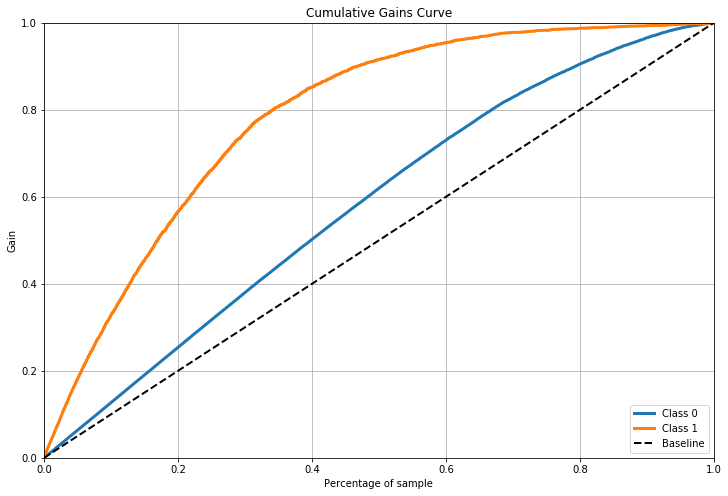

In [103]:
# Try cumulative response curve
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(data_test['result'], total_lg, figsize = (12,8))

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


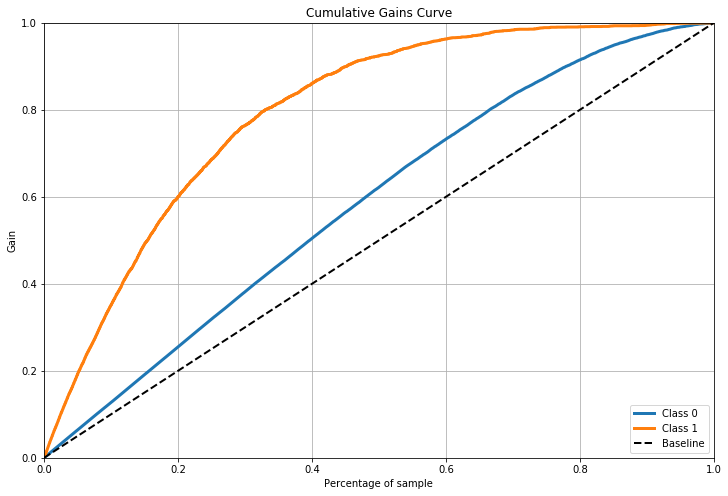

In [104]:
skplt.metrics.plot_cumulative_gain(data_test['result'], total_DT, figsize = (12,8))